In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('./library')
sys.path.append('../common')

In [3]:
import pickle

import pandas as pd
import numpy as np
from item_based import ItemBasedRecommender
from metrics import TestMetricsCalculator, RmseCalculator
from tune_k_item_based import tune_k
from rating import get_explicit_rating, get_implicit_rating_out_of_positive_ratings_df, split_matrix_csr, \
    sanity_check_implicit_rating, sanity_check_explicit_split, sanity_check_explicit_matrix


In [4]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
# Load Yelp dataset (JSON format)

movielens_file_path = "../../eda/dataset_samples/df_movie_lens.parquet"
movielens_df = pd.read_parquet(movielens_file_path)
movielens_df.head()




,user_id,movie_id,Rating,Date,YearMonth
0,5621,358,1,2000-05-23,2000-05
1,5112,2450,1,2000-06-30,2000-06
2,203,147,1,2000-12-16,2000-12
3,4387,1007,1,2000-08-05,2000-08
4,5980,2414,1,2000-04-28,2000-04


In [6]:
movielens_df["Date"] = pd.to_datetime(movielens_df["Date"]).astype(np.int64) // 10 ** 9
movielens_df

,user_id,movie_id,Rating,Date,YearMonth
0,5621,358,1,959040000,2000-05
1,5112,2450,1,962323200,2000-06
2,203,147,1,976924800,2000-12
3,4387,1007,1,965433600,2000-08
4,5980,2414,1,956880000,2000-04
...,...,...,...,...,...
9941,1041,2186,5,974937600,2000-11
9942,3842,1963,5,965865600,2000-08
9943,1324,1213,5,974764800,2000-11
9944,3580,353,5,966643200,2000-08


In [7]:
explicit_ratings, last_dates, user_mapping, item_mapping = get_explicit_rating(movielens_df, "user_id",
                                                                               "movie_id", "Rating", "Date")

explicit_ratings.toarray(), last_dates.toarray()

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[959040000,         0,         0, ...,         0,         0,
                 0],
        [        0, 962323200,         0, ...,         0,         0,
                 0],
        [        0,         0, 976924800, ...,         0,         0,
                 0],
        ...,
        [        0,         0,         0, ...,         0,         0,
                 0],
        [        0,         0,         0, ...,         0,         0,
                 0],
        [        0,         0,         0, ...,         0,         0,
                 0]]))

In [8]:
sanity_check_explicit_matrix(explicit_ratings=explicit_ratings, last_dates=last_dates, review_df=movielens_df,
                             user_field="user_id", item_field="movie_id")

,Source,Calculated metrics,Value
0,Explicit ratings matrix,Non-zero entries,9946
1,Last dates matrix,Non-zero entries,9946
2,Filtered review DataFrame,"Unique (user_id, business_id) pairs",9946


In [9]:
DIVISIONS = [0.1, 0.2, 0.7]

In [10]:
test_matrix, validation_matrix, train_matrix = split_matrix_csr(explicit_ratings, last_dates, DIVISIONS)
train_matrix.toarray(), validation_matrix.toarray(), test_matrix.toarray()

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [11]:
sanity_check_explicit_split(train_matrix=train_matrix, validation_matrix=validation_matrix, test_matrix=test_matrix,
                            explicit_matrix=explicit_ratings)

,Split,Number of interactions,Part of factual interactions
0,Train,7013,70.51%
1,Validation,1981,19.92%
2,Test,952,9.57%
3,Explicit total,9946,100.0%
4,Factual total,9946,100%



Starting K tuning for Item-Based Collaborative Filtering...


Testing different K values: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


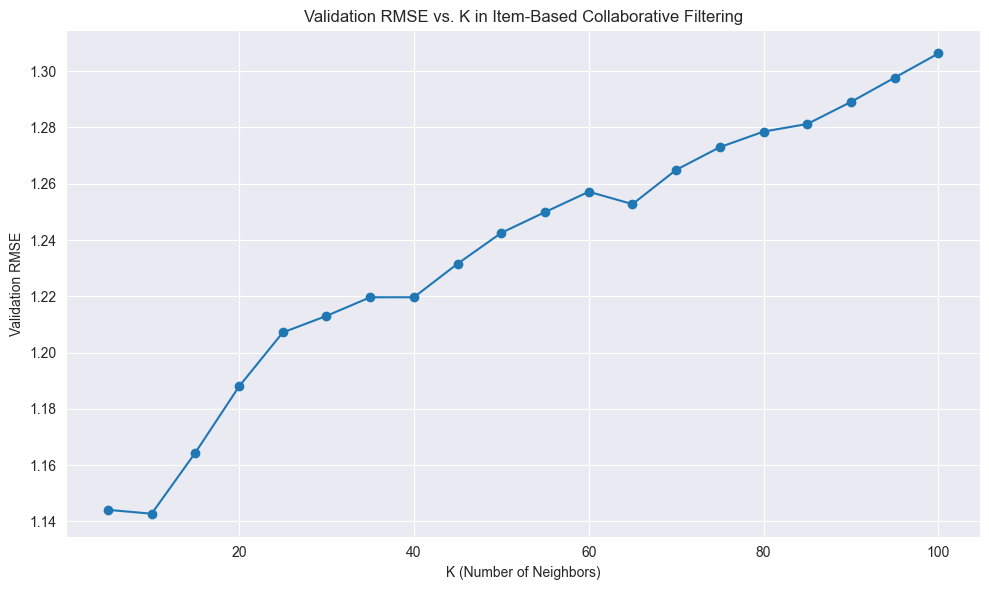


Tuning Complete
Best K (lowest validation RMSE): 10
Elbow Point K: 35
Best K (lowest validation RMSE): 10
Elbow K (stability cutoff): 35


In [12]:
# Tune k using the elbow method and lowest validation RMSE
best_k, elbow_k, results_df, *_ = tune_k(
    train_matrix,
    validation_matrix,
    test_matrix,
    user_mapping=user_mapping,
    item_mapping=item_mapping
)

print(f"Best K (lowest validation RMSE): {best_k}")
print(f"Elbow K (stability cutoff): {elbow_k}")


In [13]:
# Train the model with optimal k
recommender = ItemBasedRecommender(k=elbow_k)
recommender.fit(train_matrix, user_mapping, item_mapping)


In [14]:
with open("../../models/item_knn_colab_movie_lens.pkl", "wb") as f:
    pickle.dump(recommender, f)

In [15]:
metrics_calculator = TestMetricsCalculator(
    test_matrix=test_matrix,
    model=recommender,
    user_mapping=user_mapping,
    item_mapping=item_mapping
)

INFO:root:Create top-10 recommendations' list
INFO:root:User: 0 -- top 10 list -- [(753, 5.0), (745, 5.0), (598, 5.0), (539, 5.0), (478, 5.0), (403, 5.0), (364, 5.0), (336, 5.0), (237, 5.0), (112, 5.0)]
INFO:root:User: 1 -- top 10 list -- [(617, 5.0), (488, 5.0), (410, 5.0), (351, 5.0), (321, 5.0), (320, 5.0), (313, 5.0), (219, 5.0), (125, 5.0), (21, 5.0)]
INFO:root:User: 2 -- top 10 list -- [(741, 5.0), (620, 5.0), (516, 5.0), (447, 5.0), (415, 5.0), (353, 5.0), (249, 5.0), (236, 5.0), (71, 5.0), (20, 5.0)]
INFO:root:User: 3 -- top 10 list -- [(284, 5.0), (170, 5.0), (152, 5.0), (112, 5.0), (90, 5.0), (72, 5.0), (64, 5.0), (51, 5.0), (34, 5.0), (23, 5.0)]
INFO:root:User: 4 -- top 10 list -- [(958, 5.0), (918, 5.0), (908, 5.0), (856, 5.0), (823, 5.0), (608, 5.0), (513, 5.0), (354, 5.0), (244, 5.0), (4, 5.0)]
INFO:root:User: 5 -- top 10 list -- [(1548, 5.0), (1399, 5.0), (772, 5.0), (537, 5.0), (194, 5.0), (1140, 4.098956156458351), (155, 4.0), (142, 4.0), (128, 4.0), (94, 4.0)]
INFO:ro

In [16]:
metrics_calculator.get_test_set_statistic()

Mean popularity               0.000622
Max popularity                0.008375
Min popularity                0.000000
Number of pairs         1345638.000000
Non-null pairs (u-i)        952.000000
% of non-null pairs           0.070747
Relevant pairs (u-i)        952.000000
% of relevant pairs           0.070747
dtype: object

In [17]:
metrics_calculator.get_test_set_statistic()

Mean popularity               0.000622
Max popularity                0.008375
Min popularity                0.000000
Number of pairs         1345638.000000
Non-null pairs (u-i)        952.000000
% of non-null pairs           0.070747
Relevant pairs (u-i)        952.000000
% of relevant pairs           0.070747
dtype: object

In [18]:
rmse_calc = RmseCalculator(matrix=test_matrix, model=recommender, idx_to_user_id=user_mapping['idx_to_id'],
                      idx_to_item_id=item_mapping['idx_to_id'])

rmse_calc.calculate_rmse()

1.1171633855690364

In [19]:
metrics_calculator.generate_metrics_summary_df(rmse=rmse_calc.calculate_rmse())

There is no one relevant item in the top-10 recommendation list => Recovery can't be calculated


,Metric,Area,Value,Value Range,Meaning
0,Recovery,Relevance,None,"[0, 0.9]",How early relevant items appear in top-N recom...
1,Normalized AggDiv (diversity),Inter-user diversity,0.158291,"[0, 1]",Proportion of unique items recommended across ...
2,Normalized AggDiv (coverage),Coverage,0.419255,"[0, 1]",Proportion of unique items recommended across ...
3,Item Space Coverage,Coverage,38.743,"[0, Not defined]",Shows how many unique items and how often appe...
4,Normalized ItemDeg,Novelty,0.762,"[0, 1]",Novelty of recommended items based on inverse ...
5,Unexpectedness (no relevance),Serendipity,0.741,"[0, 1]",Proportion of items that are unexpected (less ...
6,Serendipity (with relevance),Serendipity,0.0,"[0, 1]",Proportion of unexpected and relevant items in...
7,RMSE,Relevance,1.117,"[0, 6]",Root Mean Square Error between predicted and a...


In [20]:
metrics_calculator.get_range_of_metrics()

,Metric,Min,Max,Explanation
0,Item space coverage,0,Not defined,small - recommendations focuses on several ite...
1,Recovery,0,0.9,0 - all the relevant items on the top of the l...
2,Normalized AggDiv (diversity),0,1,"0 - only 1 item was recommended for everyone, ..."
3,Normalized AggDiv (coverage),0,1,"0 - only 1 item was recommended, 1 - all the i..."
4,Unexpectedness (with_relevance=False),0,1,0 - there is no unexpected item (popularity be...
5,Serendipity (with_relevance=True),0,1,0 - there is no serendipitous item (popularity...
6,Normalized ItemDeg,0,1,0 - the most popular items are used (no novelt...
